# Multislice Least Squares (1D x–z) – Full Wirtinger Gradient (Moving Probes)
Now using multiple translated probes scanning the object (ptychographic style).

In [13]:
# Imports
import os, sys, numpy as np, matplotlib.pyplot as plt
proj_root = "/home/dnz75396/thick_ptycho"
sys.path.insert(0, proj_root)

from thick_ptycho.sample_space.sample_space import SampleSpace
from thick_ptycho.forward_model.multislice import MultiSliceForwardModel

In [14]:
bc_type = "impedance"     # Boundary condition type 
probe_type = "airy_disk"                 # Disk probe

# Constants
wavelength = 0.635  # μm
k0 = 2 * np.pi / wavelength

# background refractive index
n_medium = 1.0  # background refractive index
# Define refractive index perturbation
# delta: real part, beta: imaginary part (absorption)
delta = 0.01
beta = 0.01
refractive_index_perturbation = - delta - beta*1j 

# Spatial dimensions
xlims = [0, 40]  # μm
zlims = [0, 20]  # μm
continuous_dimensions = [xlims, zlims]


# Choose nz to satisfy paraxial resolution:
# Use approx. λ/4 axial resolution → ∆z ≈ λ / 4 ≈ 0.125 μm → nz = (z_range / ∆z)
z_range = zlims[1] - zlims[0]
dz = wavelength / 0.5
nz = int(z_range / dz)  
print(f"{nz=}")

# Discrete space parameters
probe_pixels = 10             # Discrete Probe dimensions
scan_points = 64  # image planes
step_size = 2                    # Step size in pixels


# Discrete space limits (pixels)
min_nx = int(scan_points * step_size + probe_pixels)
print(f"min_nx={min_nx}")
# Number of pixels in x directions
nx= 200
np.random.seed(7)

print(f"k={k0:.3f}, λ={wavelength:.3f}, nx={nx}, nz={nz}")

nz=15
min_nx=138
k=9.895, λ=0.635, nx=200, nz=15


In [15]:
# Rebuild sample space (moving probes)
sample_space = SampleSpace(
    continuous_dimensions=[xlims, zlims],
    discrete_dimensions=[nx, nz],
    probe_dimensions=[probe_pixels],
    scan_points=scan_points,
    step_size=step_size,
    bc_type=bc_type,
    probe_type=probe_type,
    wave_number=k0,
    n_medium=n_medium
)
x = sample_space.x if sample_space.bc_type != "dirichlet" else sample_space.x[1:-1]
z = sample_space.z
X, Z = np.meshgrid(x, z, indexing='ij')
dx, dz = sample_space.dx, sample_space.dz
print(f"dx={dx:.4f}, dz={dz:.4f}")

dx=0.2010, dz=1.4286


In [16]:
import numpy as np
gaussian_blur = 0.5

# Add 6 spheres of varying diameters and positions
common_side_length = 1  # μm diameter
common_depth = 1  # μm depth

sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,  # μm diameter
                        centre=(100/300*xlims[1], 50/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(150/300*xlims[1], 80/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
# sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(200/300*xlims[1], 110/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(220/300*xlims[1], 80/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(125/300*xlims[1], 70/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(175/300*xlims[1], 50/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
# sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(100/300*xlims[1], 110/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)

sample_space.generate_sample_space()

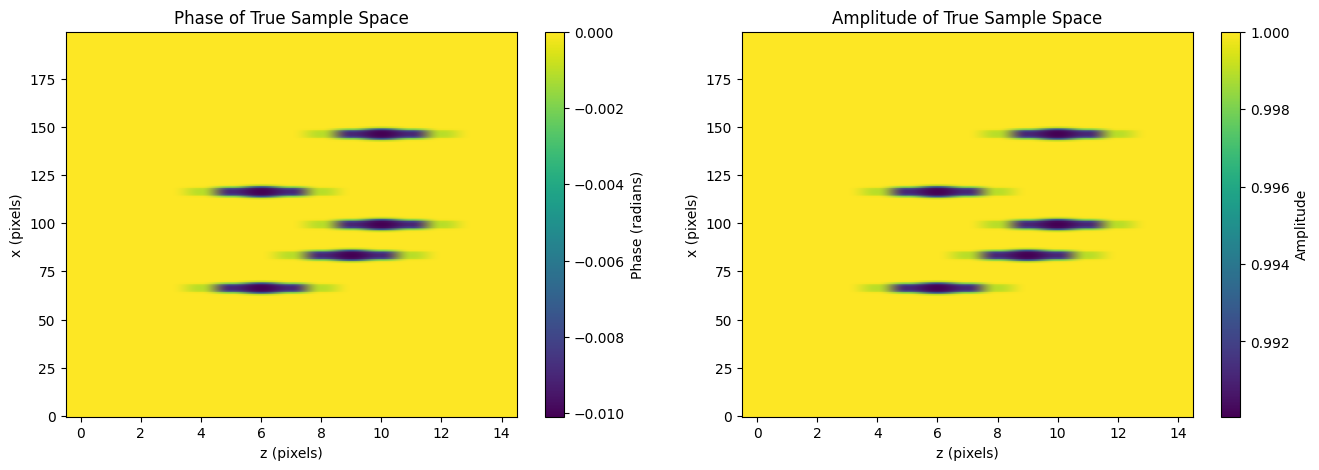

In [17]:
# Plot the true sample space
title = "True Sample Space"
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

true_phase = np.angle(sample_space.n_true)
true_amplitude = np.abs(sample_space.n_true)
vmin_phase = np.min(true_phase)
vmax_phase = np.max(true_phase)
vmin_amp = np.min(true_amplitude)
vmax_amp = np.max(true_amplitude)

# Get min and max values from the true sample space for color scaling
axs[0].set_title("Phase of True Sample Space")
im0 = axs[0].imshow(true_phase, origin='lower', aspect='auto', cmap='viridis', vmin=vmin_phase, vmax=vmax_phase)
axs[0].set_xlabel('z (pixels)')
axs[0].set_ylabel('x (pixels)')
fig.colorbar(im0, ax=axs[0], label='Phase (radians)')

# Amplitude subplot
axs[1].set_title("Amplitude of True Sample Space")
im1 = axs[1].imshow(true_amplitude, origin='lower', aspect='auto', cmap='viridis', vmin=vmin_amp, vmax=vmax_amp)
axs[1].set_xlabel('z (pixels)')
axs[1].set_ylabel('x (pixels)')
fig.colorbar(im1, ax=axs[1], label='Amplitude')

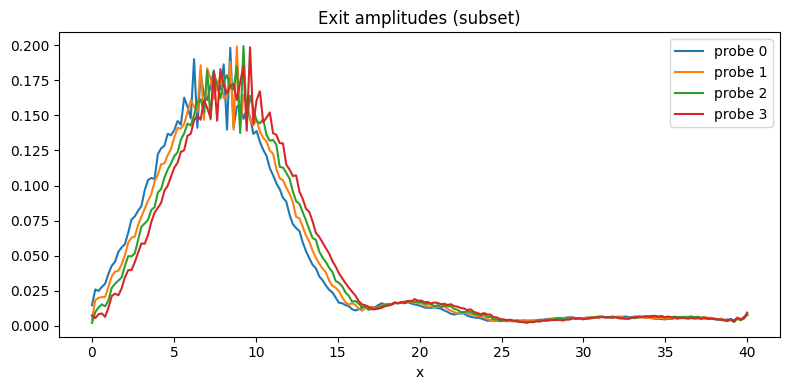

In [18]:
# Instantiate updated multislice forward model (moving probes)
ms = MultiSliceForwardModel(sample_space,
                            pad_factor=1.5,
                            angular_spectrum=True,
                            remove_global_phase=True)

field_true = ms.forward()
exit_stack = field_true[:, :, -1]
meas_amp = np.abs(exit_stack)
noise_level = 0.02
meas_amp_noisy = meas_amp * (1 + noise_level * np.random.randn(*meas_amp.shape))

plt.figure(figsize=(8,4))
for p in range(min(4, sample_space.num_probes)):
    plt.plot(x, meas_amp_noisy[p], label=f'probe {p}')
plt.title("Exit amplitudes (subset)")
plt.xlabel("x"); plt.legend(); plt.tight_layout(); plt.show()

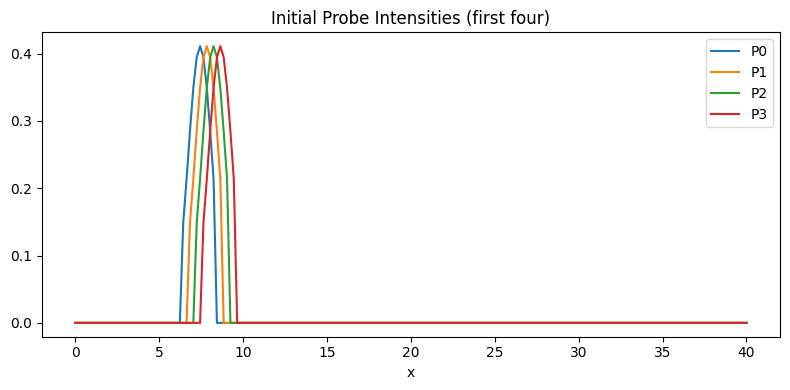

In [19]:
# Show initial probes (first 4)
probe_stack = [ms._build_probe(p) for p in range(min(4, sample_space.num_probes))]
plt.figure(figsize=(8,4))
for i, pr in enumerate(probe_stack):
    plt.plot(x, np.abs(pr), label=f'P{i}')
plt.title("Initial Probe Intensities (first four)")
plt.xlabel("x"); plt.legend(); plt.tight_layout(); plt.show()

Iter   1/10  Loss=4.906e-05  lr=1.000e-01
Iter   2/10  Loss=1.217e-03  lr=6.598e-02
Iter   3/10  Loss=6.773e-04  lr=5.173e-02
Iter   4/10  Loss=5.125e-04  lr=4.353e-02
Iter   5/10  Loss=4.708e-04  lr=3.807e-02
Iter   6/10  Loss=4.578e-04  lr=3.413e-02
Iter   7/10  Loss=4.528e-04  lr=3.111e-02
Iter   8/10  Loss=4.505e-04  lr=2.872e-02
Iter   9/10  Loss=4.494e-04  lr=2.676e-02
Iter  10/10  Loss=4.487e-04  lr=2.512e-02


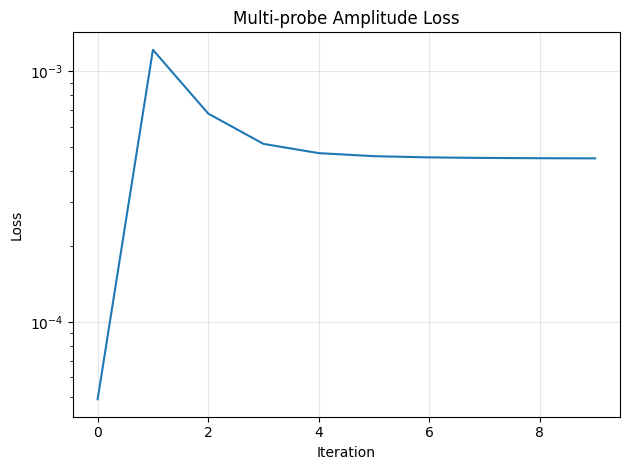

In [20]:
# Reconstruction (multi-probe loss)
n_est = np.ones_like(sample_space.n_true)
base_lr = 0.10
min_lr = 0.01
epochs = 10
l2_reg = 5.0
loss_history = []

def forward_exit(n_field):
    f = ms.forward(n=n_field)
    return f[:, :, -1], f

for it in range(epochs):
    exit_fields, _ = forward_exit(n_est)
    amp_pred = np.abs(exit_fields) + 1e-12
    diff = amp_pred - meas_amp_noisy
    loss = 0.5 * np.mean(diff**2)
    loss_history.append(loss)

    lr = max(base_lr * (1+it)**(-0.6), min_lr)

    # Accumulate gradients over probes
    grad_re_acc = np.zeros_like(n_est.real)
    grad_im_acc = np.zeros_like(n_est.real)
    for p in range(sample_space.num_probes):
        g_re, g_im = ms.full_amplitude_gradient(meas_amp_noisy[p], n=n_est)
        grad_re_acc += g_re
        grad_im_acc += g_im
    grad_re_acc /= sample_space.num_probes
    grad_im_acc /= sample_space.num_probes

    # Regularization
    grad_re_acc += l2_reg * (np.real(n_est) - n_medium)
    grad_im_acc += l2_reg * np.imag(n_est)

    n_est = (np.real(n_est) - lr * grad_re_acc) + 1j*(np.imag(n_est) - lr * grad_im_acc)

    print(f"Iter {it+1:3d}/{epochs}  Loss={loss:.3e}  lr={lr:.3e}")

plt.figure()
plt.semilogy(loss_history)
plt.xlabel("Iteration"); plt.ylabel("Loss")
plt.title("Multi-probe Amplitude Loss")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

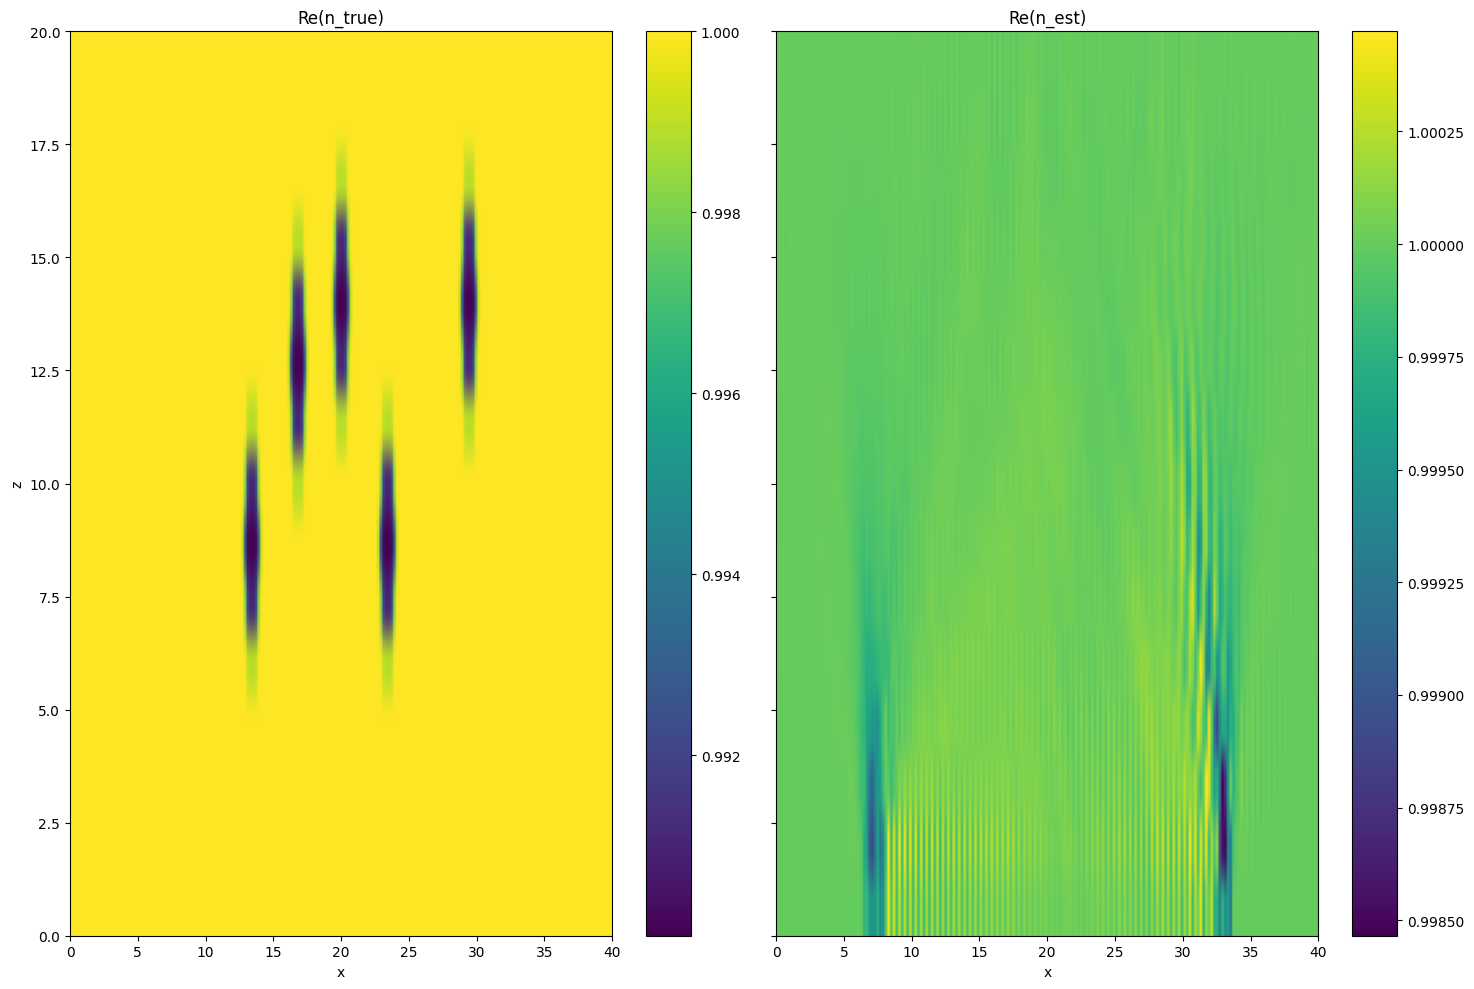

In [21]:
# Final comparison (real part)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(15,10), sharey=True)
extent=[x.min(), x.max(), z.min(), z.max()]
im0=axs[0].imshow(np.real(sample_space.n_true).T, origin='lower', aspect='auto', extent=extent, cmap='viridis')
axs[0].set_title("Re(n_true)")
im1=axs[1].imshow(np.real(n_est).T, origin='lower', aspect='auto', extent=extent, cmap='viridis')
axs[1].set_title("Re(n_est)")

for ax in axs: ax.set_xlabel("x")
axs[0].set_ylabel("z")
plt.colorbar(im0, ax=axs[0]); plt.colorbar(im1, ax=axs[1])
plt.tight_layout(); plt.show()

Notes:
- Probes now translate across x using detector_frame_info.
- Loss aggregates amplitude mismatch over all probe positions.
- Further improvements: momentum, complex regularization, probe update.